In [2]:
import os
import platform
import cv2 as cv
import json
import numpy as np
import tensorflow as tf


from sys import path
path.insert(0, '..')
import model
import config
import utill

In [3]:
with open('../assets/dataset/gt_train.txt') as file:
  data = json.load(file)

data_training = data[:88000]
data_validation = data [88000:]

print("Data length : {0}".format(len(data)))

Data length : 110000


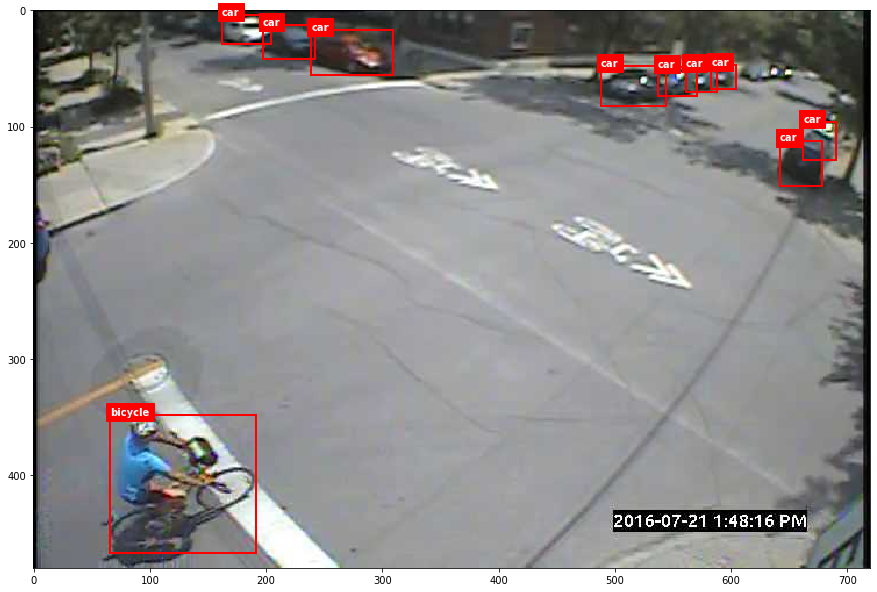

In [4]:
s = 14864
img = utill.open_image(os.path.join('../assets/dataset/train',data_validation[s]['filename']), False)
utill.draw_image(img, data_validation[s])

In [7]:
cfg = {
  'image_size' : (416, 416, 3),
  'anchors' : [16, 16, 32, 23, 25, 40, 53, 41, 46, 74, 79, 61, 106, 78, 84, 110, 136, 99, 118, 145, 174, 131, 163, 200, 248, 170, 229, 281, 344, 230],
  'strides' : [8, 16, 32],
  'xyscale': [1.2, 1.1, 1.05],
  'detector_count' : 3,
  'anchor_size_perdetector': 5,

  # Training
  'iou_loss_thresh': 0.5,
  'batch_size': 8,
  'num_gpu': 1,  # 2,

  # Inference
  'max_boxes': 100,
  'iou_threshold': 0.413,
  'score_threshold': 0.2,
}

In [8]:
mdl = model.YoloV4('../assets/class_name.txt', cfg, '../assets/yolo-v4-car.04-55.23.h5')

load from ../assets/yolo-v4-car.04-55.23.h5


# of bboxes: 13


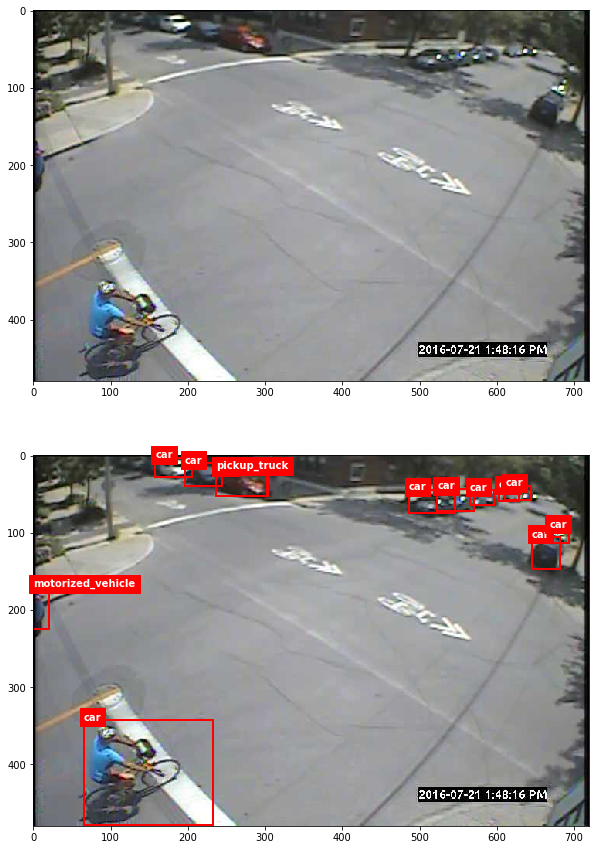

In [9]:
sample_test = os.path.join('../assets/dataset/train', data_validation[14864]['filename']) 
mdl.predict(sample_test)